# **GRUPrediction model**
This notebook will be dividided by sections as follows:\
-Data load\
-Data Preparation\
-Build GRU\
-Fit GRU\
-Forecast Predictions\

### **Data Loading**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random


confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [2]:
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,853,853,854,854,855,855,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,140,142,148,155,166,172,176,183,186,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,661,662,671,683,688,693,698,698,702,707
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,728,844,885,902,909,919,922,941,967,992
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,176,176,197,197,210,210,247,247,247,265
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,5035,5097,5160,5221,5279,5338,5399,5457,5513,5567


### **Data Preparation**
To prepare the data to feed the LSTM network, eah row is correspondant to a day and each collumn is a total for a specific country as follows:\
-Total_Cases\
-Total_Deaths\
-Total_Recoveries\
-Days_Gone

In [3]:
class Data():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        if(country == "World Wide"):
            self.PreparaDataGlobal()
        else:
            self.PreparaData()
        fator=18 # Número de dias que se corrige
        self.CorrigirCasosNegativos(fator,self.new_dataset) 
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)

    def PreparaData(self):
        confirmedPortugal = self.confirmed[ self.confirmed['Country/Region'] != self.country].index
        self.confirmed.drop(confirmedPortugal , inplace=True)
        deathsPortugal = self.deaths[ self.deaths['Country/Region'] != self.country].index
        self.deaths.drop(deathsPortugal , inplace=True)
        recoveredPortugal = self.recovered[ self.recovered['Country/Region'] != self.country].index
        self.recovered.drop(recoveredPortugal , inplace=True)
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        daily_deaths=[]
        daily_cases=[]
        day_of_week=[]
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            day_of_week.append(current_date.weekday())
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
            daily_cases.append(self.confirmed[cols].sum()-sum(daily_cases))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
            daily_deaths.append(self.deaths[cols].sum()-sum(daily_deaths))
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['WeekDay'] = day_of_week
        self.new_dataset['Daily_Cases'] = daily_cases
        self.new_dataset['Daily_Deaths'] = daily_deaths
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        
    def PreparaDataGlobal(self):
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
    
    def CorrigirCasosNegativos(self,fator,df):
        for index,row in df.iterrows():
            if(row['Daily_Cases']<0):
                df.loc[index-fator:index,'Daily_Cases']=df.loc[index-fator:index,'Daily_Cases'].sub(int(abs(row['Daily_Cases'])/fator))
                df.loc[index-fator:index,'Total_Cases']=df.loc[index-fator:index,'Total_Cases'].sub(int(abs(row['Daily_Cases'])/fator))
                row['Daily_Cases']=int(abs(row['Daily_Cases'])/fator)
        self.new_dataset = df



### **Feeding GRU**
To feed the GRU, we give 15 timesteps wich correspond to 15 individual days.\
The model uses a single column,Total_Cases, to predict the total cases for each country.\
The Model receives all data normalized in range [-1,1], this maximizes perfomance

In [4]:
class GRU():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=2
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def Denormalize(self,dfNormalized):
        pass
    
    
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:3])
                self.Y.append(self.normalized[input_index:label_index,2])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.GRU(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.GRU(64, return_sequences=True))
        self.model.add(keras.layers.GRU(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))

    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("model.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,batch_size = 7,validation_split=0.05,shuffle=False,verbose=False)
        self.model.save_weights("model.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=False)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = res
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][2])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=False)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][2] = yhat
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][2])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')
        
        
        #-------------------------------------------------Second Graph---------------------------------------------------
        
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Daily Corona Cases ', fontsize=15, color='#0c3c6e')

        plt.xlabel('Day', fontsize=10)
        plt.ylabel('Cases per day', fontsize=10)
        
        DenormalizedData = pd.read_csv('Dados/new_dataset.csv')
        
        DenormalizedData=DenormalizedData[DenormalizedData['Total_Cases']>0]
        
        df_values = pd.DataFrame()
        df_values['CasosDiarios']=DenormalizedData['Daily_Cases']
        
        df_values = df_values.reset_index()
        df_values = df_values.drop(['index'],axis=1)

        ax.bar(df_values.index,df_values[:]['CasosDiarios'],label='Real')
        last_index = df_values.index[-1] + 1
        index = []
        for i in range(len(prediction)):
            index.append(i+last_index)
        ax.bar(index,prediction,label='Previsão')
        ax.grid()
        #fig.savefig('static/Casos_diarios.png')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.show()

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = res
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][2])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()

In [5]:
class GRUDeaths():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=3
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:4])
                self.Y.append(self.normalized[input_index:label_index,3])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.GRU(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.GRU(64, return_sequences=True))
        self.model.add(keras.layers.GRU(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))
    
        
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("modelDeaths.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,batch_size = 4,validation_split=0.05,shuffle=False)
        self.model.save_weights("modelDeaths.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=True)
        print(result)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = res
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][3])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=True)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][3] = yhat
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][2])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = res
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][3])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()

In [6]:
country = "Brazil"
data = Data(country)


In [7]:
data.new_dataset

,Total_Cases,WeekDay,Daily_Cases,Daily_Deaths,Total_Recovered,Total_Deaths,Days_Gone
0,0,2,0,0,0,0,22
1,0,3,0,0,0,0,23
2,0,4,0,0,0,0,24
3,0,5,0,0,0,0,25
4,0,6,0,0,0,0,26
...,...,...,...,...,...,...,...
149,1032913,4,54771,1206,551631,48954,171
150,1067579,5,34666,1022,576779,49976,172
151,1083341,6,15762,615,588118,50591,173
152,1106470,0,23129,680,601736,51271,174


Model not found
dict_keys(['loss', 'mae', 'RMSE', 'val_loss', 'val_mae', 'val_RMSE'])


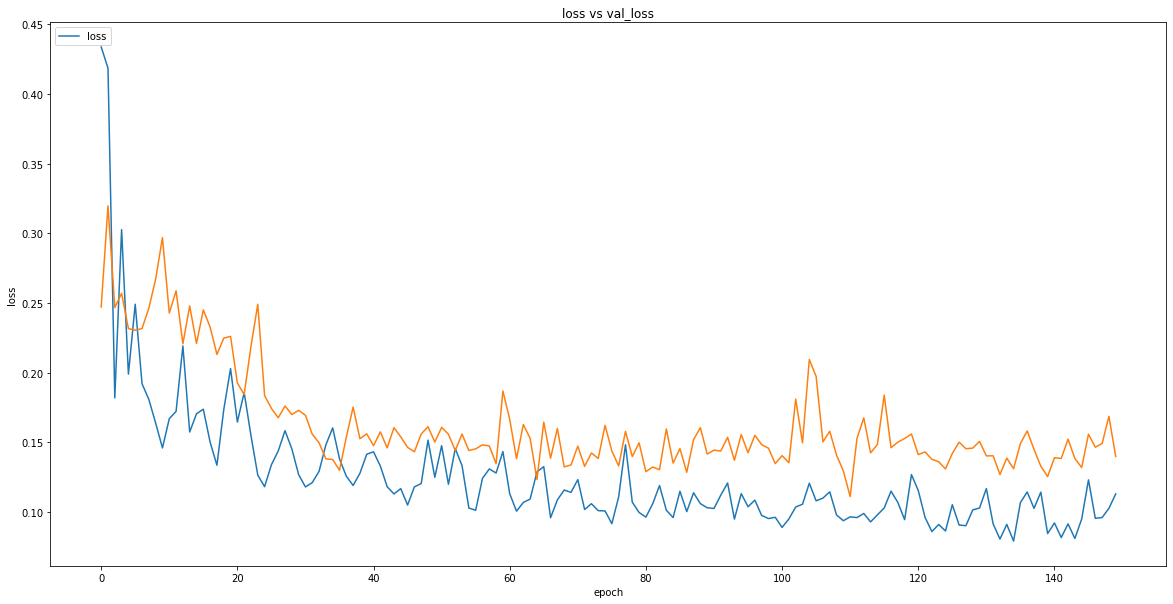

In [8]:
gru = GRU()
gru.PlotLoss()

### **Predictions**
To forecast the future, we feed the last 15 days to predict the next day, then the day predicted gets added to the dataset and the next day is predicted using the last 15 correspondant days.\
After 15 predictions, the network is using its own predictions, this may cause the error to increase but this way we can calculate when the numbers will stagnate in each country.\
The graph shown bellow show the predicted numbers for the US, to predict other countries just change the "country" variable in the cell above.

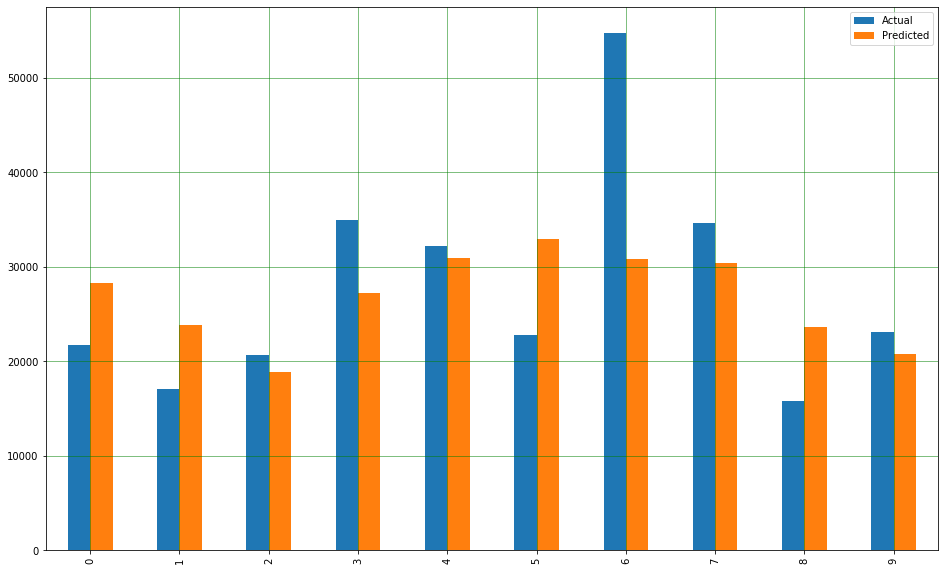

In [9]:
preds = gru.PredictTest(gru.X_test)
gru.barplot(preds)
#lstm.forecast()

In [10]:
results = gru.model.evaluate(gru.X_test,gru.Y_test)

1/1 [==============================] - 0s 94ms/step - loss: 0.3491 - mae: 0.2654 - RMSE: 0.3491


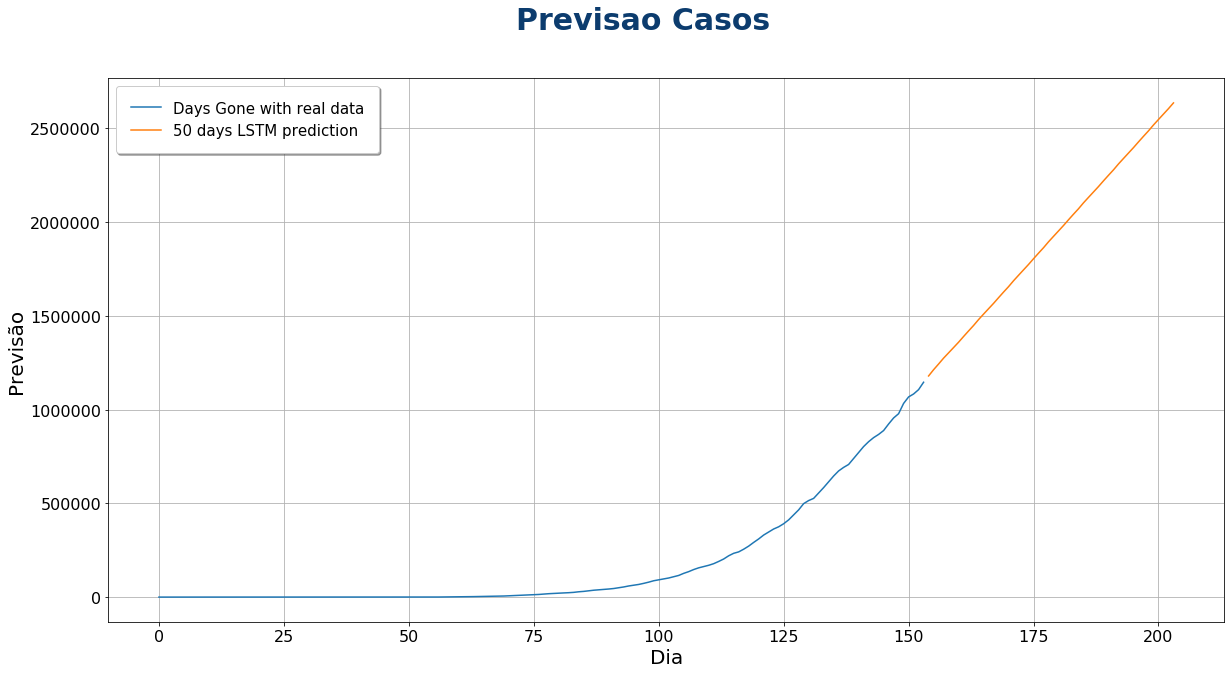

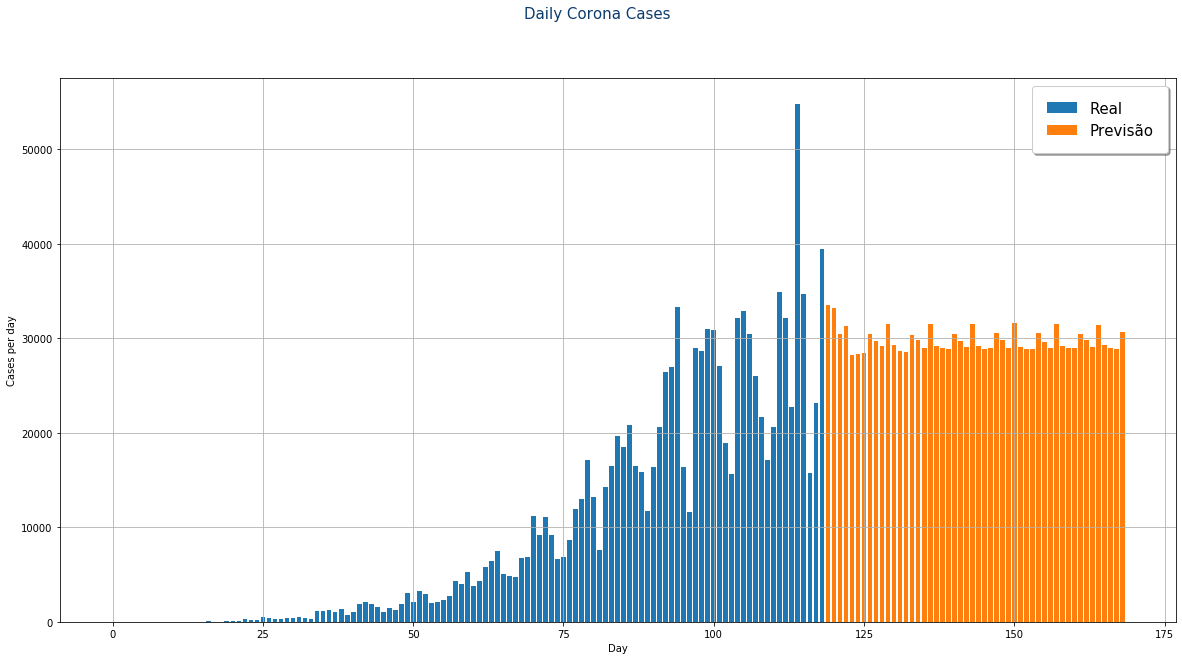

In [11]:
gru.forecast()

In [12]:
gruDeaths = GRUDeaths()

Model not found
Epoch 1/150
31/31 [==============================] - 7s 216ms/step - loss: 0.4148 - mae: 0.3856 - RMSE: 0.4138 - val_loss: 0.4926 - val_mae: 0.4254 - val_RMSE: 0.5056
Epoch 2/150
31/31 [==============================] - 3s 94ms/step - loss: 0.4446 - mae: 0.4245 - RMSE: 0.4412 - val_loss: 0.4644 - val_mae: 0.4003 - val_RMSE: 0.4745
Epoch 3/150
31/31 [==============================] - 3s 86ms/step - loss: 0.5683 - mae: 0.5531 - RMSE: 0.5591 - val_loss: 0.4072 - val_mae: 0.3669 - val_RMSE: 0.4016
Epoch 4/150
31/31 [==============================] - 3s 89ms/step - loss: 0.2710 - mae: 0.2451 - RMSE: 0.2703 - val_loss: 0.4118 - val_mae: 0.3770 - val_RMSE: 0.4046
Epoch 5/150
31/31 [==============================] - 3s 90ms/step - loss: 0.2386 - mae: 0.2160 - RMSE: 0.2407 - val_loss: 0.4757 - val_mae: 0.4095 - val_RMSE: 0.4869
Epoch 6/150
31/31 [==============================] - 2s 78ms/step - loss: 0.3047 - mae: 0.2798 - RMSE: 0.3016 - val_loss: 0.4209 - val_mae: 0.3494 - val_

Epoch 50/150
31/31 [==============================] - 3s 81ms/step - loss: 0.1610 - mae: 0.1438 - RMSE: 0.1588 - val_loss: 0.1877 - val_mae: 0.1677 - val_RMSE: 0.1883
Epoch 51/150
31/31 [==============================] - 2s 73ms/step - loss: 0.1766 - mae: 0.1529 - RMSE: 0.1789 - val_loss: 0.1897 - val_mae: 0.1467 - val_RMSE: 0.1892
Epoch 52/150
31/31 [==============================] - 3s 82ms/step - loss: 0.1605 - mae: 0.1354 - RMSE: 0.1592 - val_loss: 0.1593 - val_mae: 0.1432 - val_RMSE: 0.1582
Epoch 53/150
31/31 [==============================] - 2s 78ms/step - loss: 0.1602 - mae: 0.1392 - RMSE: 0.1571 - val_loss: 0.1518 - val_mae: 0.1281 - val_RMSE: 0.1480
Epoch 54/150
31/31 [==============================] - 2s 77ms/step - loss: 0.1544 - mae: 0.1334 - RMSE: 0.1572 - val_loss: 0.1423 - val_mae: 0.1173 - val_RMSE: 0.1408
Epoch 55/150
31/31 [==============================] - 2s 78ms/step - loss: 0.1908 - mae: 0.1721 - RMSE: 0.1937 - val_loss: 0.1982 - val_mae: 0.1625 - val_RMSE: 0.198

31/31 [==============================] - 3s 105ms/step - loss: 0.1682 - mae: 0.1508 - RMSE: 0.1667 - val_loss: 0.1440 - val_mae: 0.1349 - val_RMSE: 0.1403
Epoch 100/150
31/31 [==============================] - 3s 88ms/step - loss: 0.1339 - mae: 0.1164 - RMSE: 0.1320 - val_loss: 0.1321 - val_mae: 0.1193 - val_RMSE: 0.1316
Epoch 101/150
31/31 [==============================] - 3s 88ms/step - loss: 0.1597 - mae: 0.1311 - RMSE: 0.1658 - val_loss: 0.1547 - val_mae: 0.1270 - val_RMSE: 0.1587
Epoch 102/150
31/31 [==============================] - 3s 81ms/step - loss: 0.1628 - mae: 0.1394 - RMSE: 0.1625 - val_loss: 0.2522 - val_mae: 0.2123 - val_RMSE: 0.2569
Epoch 103/150
31/31 [==============================] - 3s 84ms/step - loss: 0.1929 - mae: 0.1732 - RMSE: 0.1894 - val_loss: 0.1677 - val_mae: 0.1367 - val_RMSE: 0.1672
Epoch 104/150
31/31 [==============================] - 3s 84ms/step - loss: 0.1158 - mae: 0.0967 - RMSE: 0.1146 - val_loss: 0.1480 - val_mae: 0.1272 - val_RMSE: 0.1510
Epoch

Epoch 148/150
31/31 [==============================] - 2s 79ms/step - loss: 0.1206 - mae: 0.1012 - RMSE: 0.1191 - val_loss: 0.2382 - val_mae: 0.2068 - val_RMSE: 0.2420
Epoch 149/150
31/31 [==============================] - 3s 87ms/step - loss: 0.1313 - mae: 0.1116 - RMSE: 0.1330 - val_loss: 0.2420 - val_mae: 0.1982 - val_RMSE: 0.2436
Epoch 150/150
31/31 [==============================] - 3s 83ms/step - loss: 0.1364 - mae: 0.1177 - RMSE: 0.1409 - val_loss: 0.1708 - val_mae: 0.1422 - val_RMSE: 0.1673


dict_keys(['loss', 'mae', 'RMSE', 'val_loss', 'val_mae', 'val_RMSE'])


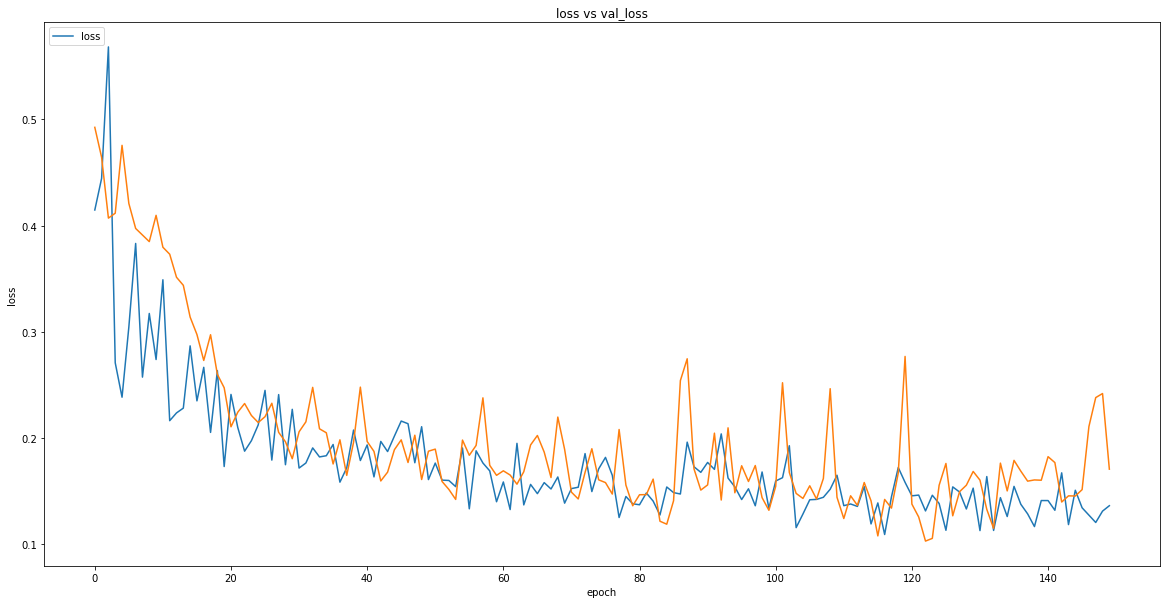

1/1 [==============================] - 0s 1ms/step
[[ 0.16995892]
 [-0.20387441]
 [ 0.07590348]
 [ 0.4163991 ]
 [ 0.57229805]
 [ 0.61911   ]
 [ 0.38117608]
 [ 0.2974827 ]
 [-0.5204636 ]
 [ 0.38090512]]


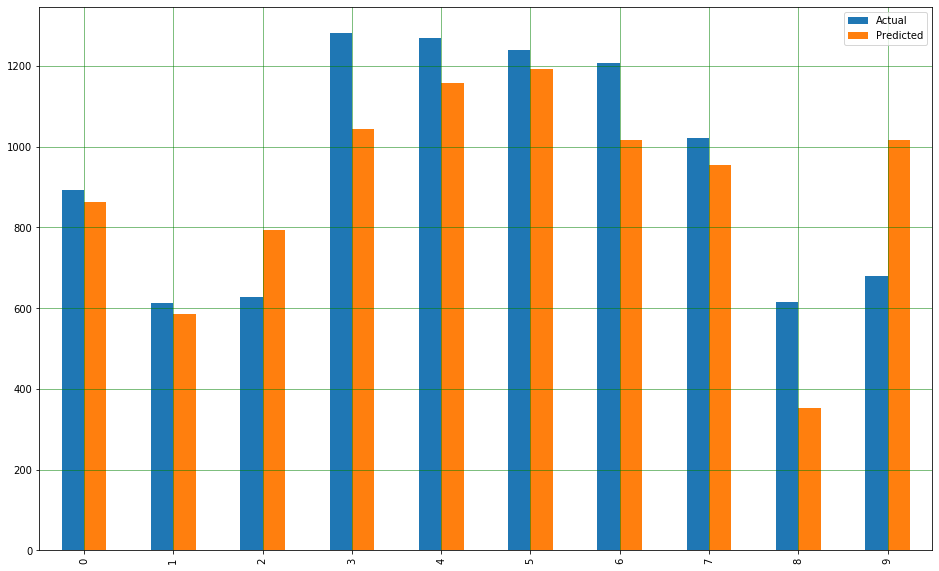

In [13]:
gruDeaths.PlotLoss()
preds = gruDeaths.PredictTest(gruDeaths.X_test)
gruDeaths.barplot(preds)